# Dressed State

#### We can study the dressed state picture from like the laser assisted electron scattering process (LAES) in also superfluid.

#### reference:  http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.123201

In [1]:
import numpy as np
from scipy.optimize import curve_fit, root

# visualization tools
import matplotlib.pyplot as plt
from qiskit.visualization.bloch import Bloch

In [2]:
import qiskit.pulse as pulse
from qiskit.pulse.library import Gaussian, GaussianSquare
from qiskit.compiler import assemble
import qiskit.ignis

from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

C:\Users\user1\AppData\Local\Temp\ipykernel_9300\1985559572.py:4: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis


In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# function for constructing duffing models
from qiskit.providers.aer.pulse import duffing_system_model

In [4]:
# cutoff dimension
dim_oscillators = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9, 5.2e9]
anharm_freqs = [-0.33e9, -0.33e9]

# drive strengths
drive_strengths = [0.02e9, 0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.002e9)
coupling_dict = {(0,1): 0.002e9}

# sample duration for pulse instructions
dt = 1e-9

# create the model
two_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

In [5]:
# list of qubits to be used throughout the notebook
qubits = [0, 1]

# Construct a measurement schedule and add it to an InstructionScheduleMap
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_width = 1150
meas_pulse = GaussianSquare(duration=meas_samples, amp=meas_amp,
                            sigma=meas_sigma, width=meas_width)

acq_sched = pulse.Acquire(meas_samples, pulse.AcquireChannel(0), pulse.MemorySlot(0))
acq_sched += pulse.Acquire(meas_samples, pulse.AcquireChannel(1), pulse.MemorySlot(1))

measure_sched = pulse.Play(meas_pulse, pulse.MeasureChannel(0)) | pulse.Play(meas_pulse, pulse.MeasureChannel(1)) | acq_sched

inst_map = pulse.InstructionScheduleMap()
inst_map.add('measure', qubits, measure_sched)

In [6]:
# construct Rabi experiments
drive_amps = np.linspace(0, 0.9, 48)
drive_sigma = 16
drive_duration = 128
drive_channels = [pulse.DriveChannel(0), pulse.DriveChannel(1)]


rabi_experiments, rabi_amps = rabi_schedules(amp_list=drive_amps,
                                             qubits=qubits,
                                             pulse_width=drive_duration,
                                             pulse_sigma=drive_sigma,
                                             drives=drive_channels,
                                             inst_map=inst_map,
                                             meas_map=[[0, 1]])

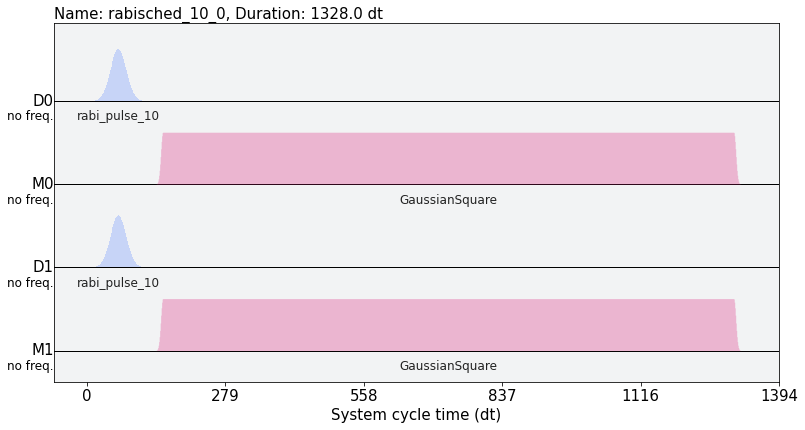

In [7]:
rabi_experiments[10].draw()

In [8]:
# instantiate the pulse simulator
backend_sim = PulseSimulator(system_model=two_qubit_model)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

rabi_qobj = assemble(rabi_experiments,
                     backend=backend_sim,
                     qubit_lo_freq=qubit_lo_freq,
                     meas_level=1,
                     meas_return='avg',
                     shots=512)

In [9]:
# run the simulation
rabi_result = backend_sim.run(rabi_qobj).result()

Pi Amp: 0.619995
Pi Amp: 0.627367


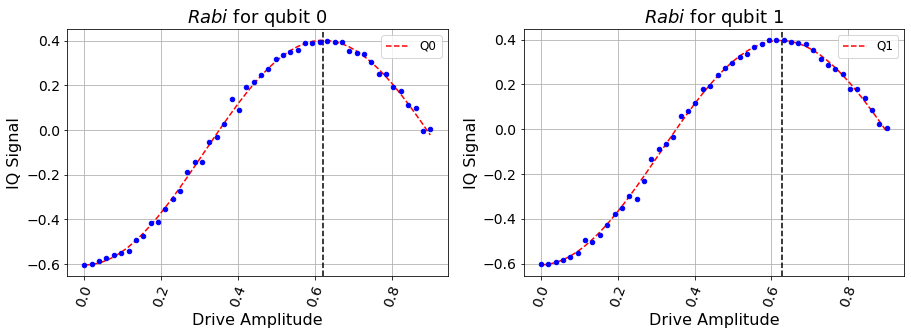

In [10]:
rabifit = RabiFitter(rabi_result, rabi_amps, qubits, fit_p0 = [0.5,0.5,0.6,1.5])

plt.figure(figsize=(15, 10))
q_offset = 0
for qubit in qubits:
    ax = plt.subplot(2, 2, qubit + 1)
    rabifit.plot(qubit, ax=ax)
    print('Pi Amp: %f'%rabifit.pi_amplitude(qubit))
plt.show()

In [11]:
two_qubit_model.control_channel_index((1,0))

1

In [12]:
# store the pi amplitudes from Section 2 in a list
pi_amps = [rabifit.pi_amplitude(0), rabifit.pi_amplitude(1)]

def cr_drive_experiments(drive_idx,
                         target_idx,
                         flip_drive_qubit = False,
                         cr_drive_amps=np.linspace(0, 0.9, 16),
                         cr_drive_samples=800,
                         cr_drive_sigma=4,
                         pi_drive_samples=128,
                         pi_drive_sigma=16):
    """Generate schedules corresponding to CR drive experiments.

    Args:
        drive_idx (int): label of driven qubit
        target_idx (int): label of target qubit
        flip_drive_qubit (bool): whether or not to start the driven qubit in the ground or excited state
        cr_drive_amps (array): list of drive amplitudes to use
        cr_drive_samples (int): number samples for each CR drive signal
        cr_drive_sigma (float): standard deviation of CR Gaussian pulse
        pi_drive_samples (int): number samples for pi pulse on drive
        pi_drive_sigma (float): standard deviation of Gaussian pi pulse on drive

    Returns:
        list[Schedule]: A list of Schedule objects for each experiment
    """

    # Construct measurement commands to be used for all schedules
    meas_amp = 0.025
    meas_samples = 1200
    meas_sigma = 4
    meas_width = 1150
    meas_pulse = GaussianSquare(duration=meas_samples, amp=meas_amp,
                               sigma=meas_sigma, width=meas_width)

    acq_sched = pulse.Acquire(meas_samples, pulse.AcquireChannel(0), pulse.MemorySlot(0))
    acq_sched += pulse.Acquire(meas_samples, pulse.AcquireChannel(1), pulse.MemorySlot(1))

    # create measurement schedule
    measure_sched = (pulse.Play(meas_pulse, pulse.MeasureChannel(0)) |
                     pulse.Play(meas_pulse, pulse.MeasureChannel(1))|
                     acq_sched)

    # Create schedule
    schedules = []
    for ii, cr_drive_amp in enumerate(cr_drive_amps):

        # pulse for flipping drive qubit if desired
        pi_pulse = Gaussian(duration=pi_drive_samples, amp=pi_amps[drive_idx], sigma=pi_drive_sigma)

        # cr drive pulse
        cr_width = cr_drive_samples - 2*cr_drive_sigma*4
        cr_rabi_pulse = GaussianSquare(duration=cr_drive_samples,
                                       amp=cr_drive_amp,
                                       sigma=cr_drive_sigma,
                                       width=cr_width)

        # add commands to schedule
        schedule = pulse.Schedule(name='cr_rabi_exp_amp_%s' % cr_drive_amp)

        # flip drive qubit if desired
        if flip_drive_qubit:
            schedule += pulse.Play(pi_pulse, pulse.DriveChannel(drive_idx))

        # do cr drive
        # First, get the ControlChannel index for CR drive from drive to target
        cr_idx = two_qubit_model.control_channel_index((drive_idx, target_idx))
        schedule += pulse.Play(cr_rabi_pulse, pulse.ControlChannel(cr_idx))  << schedule.duration


        schedule += measure_sched << schedule.duration

        schedules.append(schedule)
    return schedules

In [13]:
def plot_cr_pop_data(drive_idx,
                     target_idx,
                     sim_result,
                     cr_drive_amps=np.linspace(0, 0.9, 16)):
    """Plot the population of each qubit.

    Args:
        drive_idx (int): label of driven qubit
        target_idx (int): label of target qubit
        sim_result (Result): results of simulation
        cr_drive_amps (array): list of drive amplitudes to use for axis labels
    """

    amp_data_Q0 = []
    amp_data_Q1 = []

    for exp_idx in range(len(cr_drive_amps)):
        exp_mem = sim_result.get_memory(exp_idx)
        amp_data_Q0.append(np.abs(exp_mem[0]))
        amp_data_Q1.append(np.abs(exp_mem[1]))

    plt.plot(cr_drive_amps, amp_data_Q0, label='Q0')
    plt.plot(cr_drive_amps, amp_data_Q1, label='Q1')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('CR (Target Q{0}, driving on Q{1})'.format(target_idx, drive_idx), fontsize=20)
    plt.grid(True)

def bloch_vectors(drive_idx, drive_energy_level, sim_result):
    """Plot the population of each qubit.

    Args:
        drive_idx (int): label of driven qubit
        drive_energy_level (int): energy level of drive qubit at start of CR drive
        sim_result (Result): results of simulation

    Returns:
        list: list of Bloch vectors corresponding to the final state of the target qubit
              for each experiment
    """

    # get the dimension used for simulation
    dim = int(np.sqrt(len(sim_result.get_statevector(0))))


    # get the relevant dressed state indices
    idx0 = 0
    idx1 = 0
    if drive_idx == 0:
        if drive_energy_level == 0:
            idx0, idx1 = 0, dim
        elif drive_energy_level == 1:
            idx0, idx1 = 1, dim + 1
    if drive_idx == 1:
        if drive_energy_level == 0:
            idx0, idx1 = 0, 1
        elif drive_energy_level == 1:
            idx0, idx1 = dim, dim + 1

    # construct Pauli operators for correct dressed manifold
    state0 = np.array([two_qubit_model.hamiltonian._estates[idx0]])
    state1 = np.array([two_qubit_model.hamiltonian._estates[idx1]])

    outer01 = np.transpose(state0)@state1
    outer10 = np.transpose(state1)@state0
    outer00 = np.transpose(state0)@state0
    outer11 = np.transpose(state1)@state1

    X = outer01 + outer10
    Y = -1j*outer01 + 1j*outer10
    Z = outer00 - outer11

    # function for computing a single bloch vector
    bloch_vec = lambda vec: np.real(np.array([np.conj(vec)@X@vec, np.conj(vec)@Y@vec, np.conj(vec)@Z@vec]))

    return [bloch_vec(sim_result.get_statevector(idx)) for idx in range(len(sim_result.results))]

def plot_bloch_sphere(bloch_vectors):
    """Given a list of Bloch vectors, plot them on the Bloch sphere

    Args:
        bloch_vectors (list): list of bloch vectors
    """
    sphere = Bloch()
    sphere.add_points(np.transpose(bloch_vectors))
    sphere.show()

In [14]:
# construct experiments
drive_idx = 1
target_idx = 0
flip_drive = False
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1,
                        meas_return='avg',
                        shots=512)

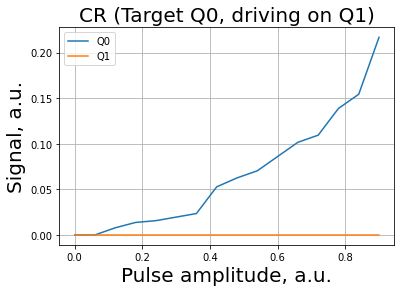

In [15]:
sim_result = backend_sim.run(cr_rabi_qobj).result()

plot_cr_pop_data(drive_idx, target_idx, sim_result)

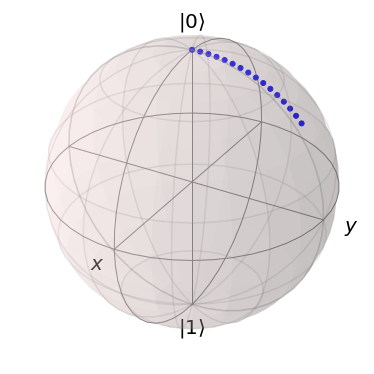

In [16]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

In [17]:
# construct experiments, now with flip_drive == True
drive_idx = 1
target_idx = 0
flip_drive = True
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1,
                        meas_return='avg',
                        shots=512)

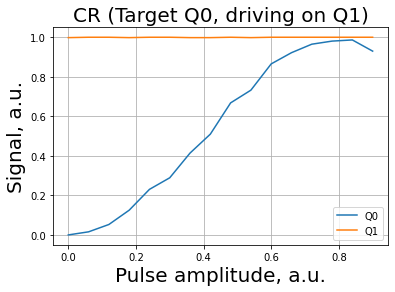

In [18]:
sim_result = backend_sim.run(cr_rabi_qobj).result()

plot_cr_pop_data(drive_idx, target_idx, sim_result)

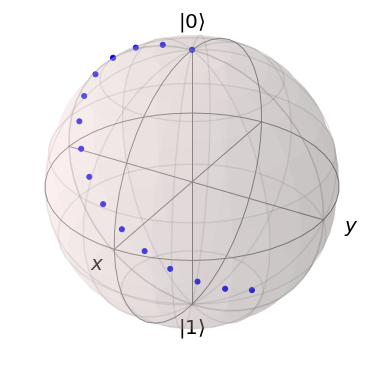

In [19]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright